# Model Pipeline
In this jupyter notebook I will demonstrate how full model pipeline will work. This is just for demonstration purposes. Lot of intermediate data processing steps are missing. Performance of model will be poor.

<img src='pipeline.jpg'>

Let's start by loading some packages.

In [3]:
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
from scipy.misc import imread
import random
import sys
import io
import os
import glob
import IPython
import time
import matplotlib.pyplot as plt
from keras.models import load_model
# from RNN_model import *
%matplotlib inline

**Initialize some variables which will be used by orca detection model.**

In [4]:
Tx = 5511 # The number of time steps input to the RNN model from the spectrogram
n_freq = 101 # Number of frequencies input to the RNN model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our RNN model

### Load pre-trained Orca detection model

In [5]:
model = load_model('./checkpoints/modelOld.h5')

### Function which returns the spectrogram of acoustic data

In [6]:
def graph_spectrogram(data):
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

### Function to pad data
This function pads our data so that sliding windows will fit it perfectly. The maximum padding required will be of the size of `stride` of sliding windows.

If size of input data is less than the window size. Then data will be padded to the size of window.

In [7]:
def get_padded_data(data, stride):
    if data.shape[0]>=441000:
        slides_before_padding = math.ceil(((data.shape[0]-441000)/stride))
        padding = (slides_before_padding*stride) - data.shape[0] + 441000
        padded_data = np.zeros((padding + data.shape[0], 2))
        padded_data[0:len(data[:])] = data[:]
    else:
        padded_data = np.zeros((441000, 2))
        padded_data[0:len(data[:])] = data[:]
    return padded_data

### Detect triggerword
This is the function that actually uses the sliding windows while predicting. It will return the array of predictions. 

In [8]:
import math
def detect_triggerword(filename, chunk):    
    rate, data = wavfile.read(filename)
    stride = int(44100*chunk)
    pred_stride = 70   
    data = get_padded_data(data, stride)
    total_slides = int(((data.shape[0]-441000)/stride)) + 1
    
    total_preds_len = ((total_slides-1)*pred_stride) + 1375
    preds = np.zeros((1, total_preds_len, 1), dtype=np.float32)
    length = data.shape[0]
#     print("Preds len: "+str(total_preds_len))
    start = 0
    pred_start = 0
    i = 0
    print("Total window slides: "+str(total_slides))
    while start+441000 <= data.shape[0]:
        segment = data[start:start+441000]
#         print("Seg Len : " + str(len(segment)))
        x = graph_spectrogram(segment)
        x  = x.swapaxes(0,1)
        x = np.expand_dims(x, axis=0)
        model_preds = model.predict(x)
        for i in range(len(model_preds[0,:,0])):
#             print("first half : "+str(pred_start+i))
            if  preds[0,pred_start+i, 0] < model_preds[0, i, 0]:
                preds[0,pred_start+i, 0] = model_preds[0, i, 0]
        
        start = start+stride
        pred_start = pred_start + pred_stride
                    
    return preds

In [9]:
filename = "joined1.wav"
r, data = wavfile.read(filename)
data.shape
stride = 22050
data = get_padded_data(data, stride)
IPython.display.Audio(filename)

Total window slides: 7


C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


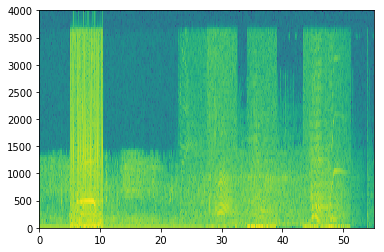

In [10]:
preds = detect_triggerword(filename, 0.5)

### Chime on Output

The following function will take model predictions, original audio and a threshold value as input. Then after doing some calculations it returns time of orca calls as a list. This list will be used by classification model.

As an utility this function also saves the audio file with chime sound at the end of orca calls.

In [11]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    times = []
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    start_of_orca = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            print("Start Time : " + str(((i-75) / Ty) * audio_clip.duration_seconds))
            times.append(((i-75) / Ty) * audio_clip.duration_seconds)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')
    return times

In [12]:
call_times = chime_on_activate(filename, preds, 0.5)

Start Time : 4.314206128133705
Start Time : 9.020612813370475
Start Time : 11.074317548746519


In [13]:
IPython.display.Audio("./chime_output.wav")

## Classifier

In [14]:
labelDict = {"0": "weeya",
	"1": "weeya",
	"2": "weeya",
	"3": "weeya",
	"4": "weeya",
	"5": "a",
	"6": "updownup",
	"7": "richochet",
	"8": "richochet",
	"9": "richochet",
	"10": "a",
	"11": "c",
	"12": "b",
	"13": "weeya",
	"14": "updownup",
	"15": "updownup",
	"16": "updownup",
	"17": "swoop",
	"18": "updownup"
}

label_to_num = {}
for i,val in enumerate(set(labelDict.values())):
    label_to_num[val] = i
    
label_to_num["negative"] = len(label_to_num)

num_to_label = {}
for key, val in label_to_num.items():
    num_to_label[val] = key

**Load pre trained classifier model**

In [15]:
CNNmodel =  load_model("simpleModel.h5")

In [16]:
def graph_spectrogram(data):
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    plt.set_cmap('magma')
    nchannels = data.ndim
    if nchannels ==1:
        pxx, freqs, bins, im = ax.specgram(x=data, Fs=44100, noverlap=384, NFFT=512)
    if nchannels ==2:
        pxx, freqs, bins, im = ax.specgram(x=data[:,0], Fs=44100, noverlap=384, NFFT=512)
    ax.axis('off')
    return pxx

In [17]:
def preprocessImg(img):
    img = img/255
    img = img - 0.5
    img = 2*img
    
    return img

C:\Users\Babban\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Predicted class for 0 Orca call is: negative
Predicted class for 1 Orca call is: negative
Predicted class for 2 Orca call is: a


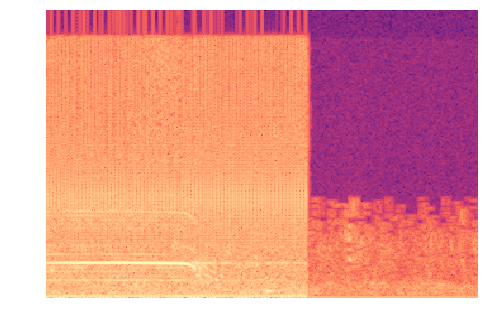

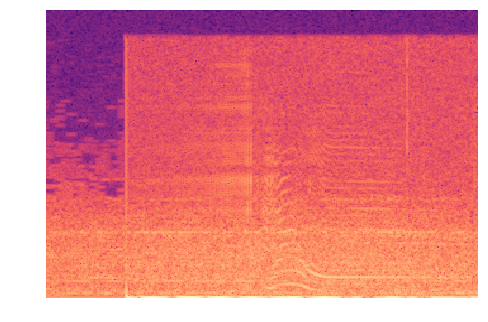

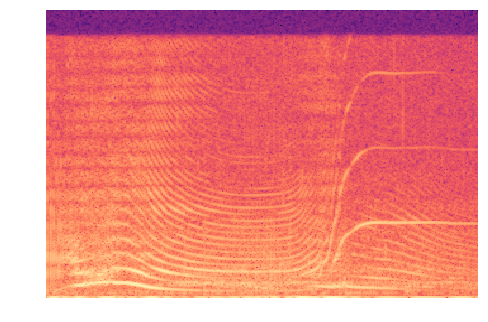

In [20]:
i = 0
for time_ in call_times:
    t = math.floor(time_*44100)
    px = graph_spectrogram(data[t:t+44100])
    plt.savefig(str(i)+'.jpg', dpi=50)
    img = imread(str(i)+'.jpg')
    img = np.expand_dims(img, 0)
    img = preprocessImg(img)
    pred = CNNmodel.predict(img)
    print("Predicted class for "+ str(i) + " Orca call is: "+ num_to_label[np.argmax(pred)])
    i+=1